# What I think needs to be refactored

- Each of the code under the for statements in the DistNodeNoParent can be its own function
  - Logic within each of the if statement could also be refactored into separate functions, for example, the logic for getting the distribution for discrete variables can be in a separate function, same for logic for getting distribution for any continuous variables.
  - The fitting function from fitter should be adjusted to avoid the excessive printing. Any way for using tqdm here?

- The for loop within SimNodeNoParent should be a separate function

- The SimulateAvailability Function should only produce an availability matrix, rather than concatenate it to the existing long format dataframe

- Each of the if statements within FitAlternativeRegression should be it's own separate function for fitting logistic regression vs. linear...

- We should write functions that take in a format of regression and produces the needed data. (for all regression equations)

- The for loop that simulates data N times and estimates any models should be written as a helper function.

- Helper function to plot the distribution of causal effects

- Helper function to recompute the regressions after the perturbations of variables.

- All the conditions are also to be written as separate methods.

- We have plenty of parameters that repeat themselves in multiple methods. I think it would be beneficial to create a parameter object that would store all these parameters and allow us to call methods using only one parameter. This will be helpful (in my opinion) while experimenting with different model specifications for example; We would not have to create numerous variables each time for each of the models. Instead, we will create an object (it should be a class in my opinion) from a collection of parameters, then just insert that class in all of our methods for that specific model. The parameters will be attributes of the class.

# Importing packages 

In [1]:
import sys
sys.path.append('../../src/')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
import seaborn as sns
import statsmodels.api as sm
import copy
from scipy import sparse
import scipy.stats
import random
from fitter import Fitter
import attr
from causalgraphicalmodels import CausalGraphicalModel, StructuralCausalModel
from collections import defaultdict, OrderedDict
import pylogit as pl
import viz
from array import array

# 1. Defined Functions 

In [8]:
def DistNodeNoParent(data_long,
                     alt_id_col,
                     obs_id_col,
                     alt_spec_dic,
                     alt_name_dic,
                     ind_spec,
                     trip_spec,
                     var_types,
                     cont_dists=None):
    """
    Function to find the distribution of specific variables
    from a long format dataset.

    Parameters
    ----------
    data_long: Pandas DataFrame
        Dataset in long format from which variable
        distribution is to be found.

    alt_id_col: string
        Name of the column with alternative ids.

    obs_id_col: string
        Name of the column with observation ids.

    alt_spec_dic: dictionary
        Dictionary with keys as the ordered number
        of alternatives, and the value for each key
        is a list of strings representing the name of
        variables without parents per alternative.

    alt_name_dic: dictionary
        Dictionary with keys as the ordered number
        of alternatives, and the value for each key
        is a string representing the name of the 
        alternative.

    ind_spec: list
        List containing strings of the names of 
        individual specific variables.

    trip_spec: list
        List containing string of the names of 
        trip specific variables.

    var_types: dictionary
        Dictionary with keys as strings of names of variables
        from long format dataset, and values for each key are
        the type of variables (e.g.: 'categorical vs. continuous').

    cont_dists: list
        List of continuous RVs distribution names from scipy.

    Returns
    -------
    a nested dictionary with keys as variable names and values
    as dictionaries containing both the distribution name and
    its parameters.
    """

    params_dict = {}

    # Code for Individual Specific Variables
    for ind in ind_spec:
        # generate array of values for individual specific variable
        ind_var = pd.Series([(data_long.loc[data_long[obs_id_col] == x][ind].unique()[0]) for x in data_long[obs_id_col].unique()])  
        # Get distribution if variable is categorical
        var_type = var_types[ind]
        if var_type in ['categorical', 'numerical']:
            # If only one category
            if len(ind_var.unique()) == 1:
                params_dict.setdefault(ind,{})['distribution'] = 'constant'
                params_dict.setdefault(ind,{})['parameters'] = ind_var.unique()
            # If more than one category
            else:
                params_dict.setdefault(ind,{})['distribution'] = 'categorical'
                # Count frequency of values and store it as paramater of distribution
                np_array_range = np.arange(ind_var.max()+1)
                array_bincount = np.bincount(ind_var)
                probs = array_bincount / len(ind_var)
                params_dict.setdefault(ind,{})['parameters'] = [np_array_range,
                                                  probs]
        else:
            # If not categorical but just one unique value
            if len(ind_var.unique()) == 1:
                params_dict.setdefault(ind,{})['distribution'] = 'constant'
                params_dict.setdefault(ind,{})['parameters'] = ind_var.unique()
            # If not categorical but not one unique value
            else:
                # Use the Fitter library to fit distributions
                # to the data
                fitter_object = Fitter(data=ind_var,
                                       distributions=cont_dists,
                                       timeout=60)
                fitter_object.fit()
                # Get the best distribution and store in dictionary
                BestDict = fitter_object.get_best()
                params_dict.setdefault(ind,{})['distribution'] = list(BestDict.items())[0][0]
                params_dict.setdefault(ind,{})['parameters'] = list(BestDict.items())[0][1]

    # Code for Alternative Specific Variables
    # Loop around the different available alternatives
    for alt in data_long[alt_id_col].unique():
        # Store data for specific alternative (mode)
        mode_data = data_long.loc[data_long[alt_id_col] == alt]
        # Loop around the alternative specific variables in the input dictionary
        for var in alt_spec_dic[alt]:
            # If data is to be taken as empirical values
            if var_types[var] == 'empirical':
                # If only one value
                if len(mode_data[var].unique()) == 1:
                    # Add name of alternative to variable and store distriburion & parameters
                    params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['distribution'] = 'constant'
                    params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['parameters'] = mode_data[var].unique()
                else:
                    # Add name of alternative to variable and store distriburion & parameters
                    params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['distribution'] = 'empirical'
                    params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['parameters'] = np.array(mode_data[var])
            # If data is categorical
            elif var_types[var] == 'categorical':
                # If only one category
                if len(mode_data[var].unique()) == 1:
                    # Add name of alternative to variable and store distriburion & parameters
                    params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['distribution'] = 'constant'
                    params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['parameters'] = mode_data[var].unique()
                else:
                    # If more than one category, compute the frequency of values
                    # and store as parameters
                    # Add name of alternative to variable and store distriburion & parameters
                    params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['distribution'] = 'categorical'
                    np_array_range = np.arange(mode_data[var].max()+1)
                    array_bincount = np.bincount(mode_data[var])
                    probs = array_bincount / len(mode_data[var])
                    params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['parameters'] = [np_array_range,
                                                                            probs]
            else:
                # If data is not categorical but has one unique value
                if len(mode_data[var].unique()) == 1:
                    # Add name of alternative to variable and store distriburion & parameters
                    params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['distribution'] = 'constant'
                    params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['parameters'] = mode_data[var].unique()
                # If data is not categorical but has more than one unique value
                else:
                    # Use the Fitter library to fit distributions
                    # to the data
                    fitter_object = Fitter(data=mode_data[var],
                                           distributions=cont_dists,
                                           timeout=60)
                    fitter_object.fit()
                    # Get the best distribution and store in dictionary
                    BestDict = fitter_object.get_best()
                    # Add name of alternative to variable and store distriburion & parameters
                    params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['distribution'] = list(BestDict.items())[0][0]
                    params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['parameters'] = list(BestDict.items())[0][1]

    # Trip Specific Variable (maybe combine with individual specific variables)
    # Loop around trip (observation) specific variables
    for var in trip_spec:
        # generate array of values for trip specific variable
        trip_var = pd.Series([(data_long.loc[data_long[obs_id_col] == x][var].unique()[0]) for x in data_long[obs_id_col].unique()])
        # If data is to be taken as empirical values
        if var_types[var] == 'empirical':
            # If data has one unique value
            if trip_var.unique() == 1:
                params_dict.setdefault(var, {})['distribution'] = 'constant'
                params_dict.setdefault(var, {})['parameters'] = np.array(trip_var.unique())
            # If data has more than one unique value
            else:
                params_dict.setdefault(var, {})['distribution'] = 'empirical'
                params_dict.setdefault(var, {})['parameters'] = np.array(trip_var)
        # Get distribution if variable is categorical
        elif var_types[var] == 'categorical':
            # If only one category
            if len(trip_var.unique()) == 1:
                params_dict.setdefault(var, {})['distribution'] = 'constant'
                params_dict.setdefault(var, {})['parameters'] = trip_var.unique()
            # If more than one category
            else:
                params_dict.setdefault(var, {})['distribution'] = 'categorical'
                # Count frequency of values and store it as paramater of distribution
                np_array_range = np.arange(trip_var.max()+1)
                array_bincount = np.bincount(trip_var)
                probs = array_bincount / len(trip_var)
                params_dict.setdefault(var, {})['parameters'] = [np_array_range,
                                                  probs]
        else:
            # If not categorical but just one unique value
            if len(trip_var.unique()) == 1:
                params_dict.setdefault(var, {})['distribution'] = 'constant'
                params_dict.setdefault(var, {})['parameters'] = trip_var.unique()
            # If not categorical but just one unique value
            else:
                # Use the Fitter library to fit distributions
                # to the data
                fitter_object = Fitter(data=trip_var,
                                       distributions=cont_dists,
                                       timeout=60)
                fitter_object.fit()
                # Get the best distribution and store in dictionary
                BestDict = fitter_object.get_best()
                params_dict.setdefault(var, {})['distribution'] = list(BestDict.items())[0][0]
                params_dict.setdefault(var, {})['parameters'] = list(BestDict.items())[0][1]

    return params_dict


def SimNodeNoParent(params_dict, size=1000):
    """
    Funtion to simulate data of size N based on specified
    distribution/parameters found by the fitter package.

    Paremeters
    ----------
    dist_params: dictionary
        The variable distribution dictionary resulting from
        `FindLongDataDist`.

    size: int
        Size of the desired simulated dataset, default value
        is 1000 observations.

    Returns
    -------
    DataFrame object with simulated data based on specified distributions
    """
    # Create Empty DataFrame with keys from params_dict
    Sim_Df = pd.DataFrame(columns=list(params_dict.keys()))
    Sim_Df = Sim_Df.fillna(0)

    # Loop around each of the variables in params_dict
    # and simulate data for them
    for column in list(params_dict.keys()):
        # Simulate data for categorical variables
        if params_dict[column]['distribution'] == 'categorical':
            value = params_dict[column]['parameters'][0]
            freq = params_dict[column]['parameters'][1]
            data_sim = np.random.choice(a=value,
                                        p=freq,
                                        size=size)
            Sim_Df[column] = data_sim

        # Simulate variables for data with a single unique value
        elif params_dict[column]['distribution'] == 'constant':
            data_sim = params_dict[column]['parameters']
            Sim_Df[column] = data_sim

        # Simulate data using values from array, sampling
        # with replacement
        elif params_dict[column]['distribution'] == 'empirical':
            data_sim = np.random.choice(params_dict[column]['paramaters'], size=size)
            Sim_Df[column] = data_sim

        # Simulate data for continuous variables
        else:
            # Get scipy distribution from its
            # name in the params dictionary
            dist = getattr(scipy.stats,
                           params_dict[column]['distribution'])
            data_sim = dist.rvs(*params_dict[column]['parameters'],
                                size=size)
            Sim_Df[column] = data_sim

    return Sim_Df

def SimulateAvailability(data_long, sim_data, obs_id_col, alt_name_dict):
    """
    Function to simulate alternative availability based on a long format
    dataset and join the availability data to the simulated dataset
    resulting from SimDf.

    Parameters
    ----------
    data_long: Pandas DataFrame
        Long format dataframe used for simulating
        alternative availability.

    sim_data: Pandas DataFrame
        Wide format dataframe resulting from SimDf

    obs_id_col: string
        Name of the column in data_long with 
        observation ids.

    alt_name_dic: dictionary
        Dictionary with keys as the ordered number
        of alternatives, and the value for each key
        is a string representing the name of the 
        alternative.

    Returns
    -------
    Wide format Pandas DataFrame with additional availability
    columns for each of the alternatives.

    """

    # Create empty Series to hold number of available alternatives
    series = pd.Series([])

    # Loop around each observation to record the
    # available number of alternatives for each observation
    for i, obs in zip(np.arange(len(data_long[obs_id_col].unique())), data_long[obs_id_col].unique()):
        series[i] = data_long[data_long[obs_id_col] == obs].shape[0]

    # Simulate number of available alternatives for
    # each observation in sim_data
    av_size = sim_data.shape[0]
    alts_sim = np.random.choice(a=np.arange(series.max()+1),
                                p=np.bincount(series)/len(series),
                                size=av_size)

    # Simulate the availability matrix based on number 
    # of available alternatives
    N = len(alt_name_dict)
    av_sim = [np.array([1] * K + [0]*(N-K)) for K in alts_sim]

    # Shuffle the available alternatives for each observation
    # because av_sim will always start with 1s
    for x in av_sim:
        np.random.shuffle(x)

    # Shuffle the availability across different observations
    np.random.shuffle(av_sim)

    # Create columns for the availability matrix
    AV_columns = [alt_name_dict[i]+'_AV' for i in alt_name_dict.keys()]

    # Create alternative availability matrix with AV_columns
    AV_Df = pd.DataFrame(av_sim, columns=AV_columns)

    # Create an random choice column based on available
    # alternatives for each observation - This column will
    # be needed when converting to long data
    fake_choice = [random.choice(np.nonzero(a == 1)[0]) + 1 for a in np.array(AV_Df)]
    fake_choice_df = pd.DataFrame(fake_choice, columns=['sim_choice'])

    # Concatenate the simulated data with availability data and fake choice data
    # and return Sim_DF_AV
    Sim_DF_AV = pd.concat([sim_data, AV_Df, fake_choice_df], axis=1, sort=False)
    return Sim_DF_AV

def FitAlternativeRegression(regressions, reg_types, data):
    
    """
    Function to store regression models based on causal graph
    in a dictionary.
    
    Parameters
    ----------
    regressions: dictionary
        Dictionary with keys as integers representing the
        order of regressions. Values of the dictionary
        are tuples/lists with the first item is a string
        of the name of the independent variable and the
        second item is a string of the name of the 
        dependent variable.
    
    reg_types: dictionary
        Dictionary with keys as integers representing the
        order of regressions. Keys should be similar to the
        keys from the `regressions` dictionary. Values are
        strings representing the type of regressions to be
        ran. **TODO: add more regressions**
        
    Returns
    -------
    Dictionary with keys as the regression name and values
    as regression models stores. Methods from these fitted
    models can be accessed through the values of the dictionary.
    """
    
    # Initiate the regressions results dictionary
    regression_results = {}
    
    # Loop around the regressions
    for reg in regressions.keys():
        # If linear regression
        if reg_types[reg] == 'linear':
            # Prepare data and initialize model
            data_x = sm.add_constant(data[regressions[reg][0]])
            data_y = data[regressions[reg][1]]
            model = sm.OLS(data_y, data_x)

            # Fit model
            results = model.fit()
            
            # Store model
            regression_results[regressions[reg][1]+'_on_'+regressions[reg][0]] = results
        
        # If logistic regression **TODO: Expand on
        # logistic regression
        if reg_types[reg] == 'logistic':
            # Prepare data and initialize model
            data_x = sm.add_constant(data[regressions[reg][0]])
            data_y = data[regressions[reg][1]]
            model = sm.Logit(data_y, data_x)

            # Fit model
            results = model.fit()
            
            # Store model
            regression_results[regressions[reg][1]+'_on_'+regressions[reg][0]] = results
    
    #if plotting:
    #    fig = plt.figure(figsize=(12,8))
    #    fig = sm.graphics.plot_regress_exog(results, X[0], fig=fig)
    
    return regression_results

def PlotParams(sim_par, model, fig_size):
    """
    Function to plot parameters from simulated data.
    
    Parameters
    ----------
    sim_par: Pandas Series or Pandas Column
        Pandas Series or column from DataFrame containing
        coefficients from the estimated models based on
        simulated data.
        
    model: Pylogit model.
        Estimated data generating model to compare 
        estimated parameters based on simulated data
        to.
        
    size: tuple
        Figure size
        
    Returns
    -------
    Seaborn figure of the distribution of estimated parameters
    based on simulated data.
    """
    # Create bins for the histogram
    bins = np.linspace(sim_par.min(), sim_par.max(), 10)
    
    # Initialize the figure size
    plt.figure(figsize=fig_size)
    
    # Plot the distribution
    sns.distplot(sim_par, kde=False, bins=bins, label='Simulated Parameters')
    
    # Add vertical line for the data generating parameter
    plt.axvline(model.coefs[sim_par.name], color='black', ls='--',label='Data Generating Parameter')
    
    # Add a title for the figure
    plt.title(label='Histogram of '+'"'+sim_par.name+'"', fontdict={'fontsize':16})
    
    # Add a y-label
    plt.ylabel('Frequency', rotation=0, labelpad=50)
    
    # Add a legend
    plt.legend()

def FindOutliers(data, threshold=3.5):
    """
    Function to remove outlier data, based on
    the median absolute deviation from the median.
    Note that the function supports asymmetric 
    distributions and is based on code from the
    included reference
    
    Parameters
    ----------
    data: Pandas Series-line
        Series-like containing the simulated
        data in wide format.
        
    threshold: float
        Threshold of the Median Absolute Deviation
        above which data should be removed
        
    Returns
    -------
    Array with True values representing index
    of non-outliers
    
    References
    ----------
    https://eurekastatistics.com/using-the-median-
    absolute-deviation-to-find-outliers/
    
    TODO:
    -----
    We need to discuss whether this approach is 
    appropriate for dropping outlier observations
    """
    
    m = np.median(data)
    abs_dev = np.abs(data - m)
    left_mad = np.median(abs_dev[data <= m])
    right_mad = np.median(abs_dev[data >= m])
    data_mad = left_mad * np.ones(len(data))
    data_mad[data > m] = right_mad
    z_score = abs_dev / data_mad
    z_score[data == m] = 0
    return z_score < threshold

# 2. MNL Model Estimation using Bike Data

## 2.1. Data Ingestion and Exploration

In [9]:
# Create a variable for the path to the long format data for
# the multinomial choice model
PATH = '../../data/raw/spring_2016_all_bay_area_long_format_plus_cross_bay_col.csv'

In [10]:
# Reading data from the specified PATH
bike_data_long = pd.read_csv(PATH)

# If in previous work we accidentally saved the index with the dataframe
# remove the old index from the data
if "Unnamed: 0" in bike_data_long.columns:
    del bike_data_long["Unnamed: 0"]

print("The columns of bike_data are:")
bike_data_long.columns

The columns of bike_data are:


Index(['household_id', 'person_id', 'tour_id', 'observation_id', 'mode_id',
       'choice', 'tour_origin_taz', 'primary_dest_taz', 'total_travel_time',
       'total_travel_cost', 'total_travel_distance', 'age', 'household_size',
       'household_income', 'household_income_values', 'transit_subsidy',
       'transit_subsidy_amount', 'num_cars', 'num_licensed_drivers',
       'cross_bay', 'oakland_and_berkeley', 'survey_id', 'gender',
       'non_relative_flag', 'num_pre_school', 'num_school_aged', 'married',
       'parent', 'income_category_1', 'income_category_2', 'income_category_3',
       'income_category_4', 'income_category_5', 'income_category_6',
       'income_category_7', 'income_category_8', 'income_category_9',
       'income_category_10', 'income_unknown', 'ln_drive_cost',
       'ln_drive_cost_sq', 'total_travel_time_10x', 'total_travel_time_tenth',
       'high_income', 'medium_income', 'low_income', 'high_income_cost',
       'medium_income_cost', 'low_income_cost', 

In [11]:
# Look at the mode shares in the data set
alt_id_to_mode_name = {1: "Drive Alone",
                       2: "Shared Ride 2",
                       3: "Shared Ride 3+",
                       4: "Walk-Transit-Walk",
                       5: "Drive-Transit-Walk",
                       6: "Walk-Transit-Drive",
                       7: "Walk",
                       8: "Bike"}

mode_counts = bike_data_long.loc[bike_data_long.choice == 1,
                                 "mode_id"].value_counts().loc[range(1, 9)]

mode_shares = mode_counts / bike_data_long.observation_id.max()
mode_shares.index = [alt_id_to_mode_name[x] for x in mode_shares.index.values]
mode_shares.name = "Mode Shares"
mode_shares

Drive Alone           0.428322
Shared Ride 2         0.158841
Shared Ride 3+        0.139860
Walk-Transit-Walk     0.103397
Drive-Transit-Walk    0.015485
Walk-Transit-Drive    0.013237
Walk                  0.094406
Bike                  0.046454
Name: Mode Shares, dtype: float64

## 2.2. MNL Model Specification 

In [23]:
# Create my specification and variable names for the basic MNL model
# NOTE: - Keys should be variables within the long format dataframe.
#         The sole exception to this is the "intercept" key.
#       - For the specification dictionary, the values should be lists
#         or lists of lists. Within a list, or within the inner-most
#         list should be the alternative ID's of the alternative whose
#         utility specification the explanatory variable is entering.

mnl_specification = OrderedDict()
mnl_names = OrderedDict()

mnl_specification["intercept"] = [2, 3, 4, 5, 6, 7, 8]
mnl_names["intercept"] = ['ASC Shared Ride: 2',
                          'ASC Shared Ride: 3+',
                          'ASC Walk-Transit-Walk',
                          'ASC Drive-Transit-Walk',
                          'ASC Walk-Transit-Drive',
                          'ASC Walk',
                          'ASC Bike']

mnl_specification["total_travel_time"] = [1, 2, 3, [4, 5, 6]]
mnl_names["total_travel_time"] = ['Travel Time, units:min (Drive Alone)',
                                  'Travel Time, units:min (SharedRide-2)',
                                  'Travel Time, units:min (SharedRide-3+)',
                                  'Travel Time, units:min (All Transit Modes)']

mnl_specification["total_travel_cost"] = [1, 2, 3, [4, 5, 6]]
mnl_names["total_travel_cost"] = ['Travel Cost, units:$ (Drive Alone)',
                                  'Travel Cost, units:$ (SharedRide-2)',
                                  'Travel Cost, units:$ (SharedRide-3+)',
                                  'Travel Cost, units:$ (All Transit Modes)']

# mnl_specification["cost_per_distance"] = [1, 2, 3]
# mnl_names["cost_per_distance"] = ["Travel Cost per Distance, units:$/mi (Drive Alone)",
#                                   "Travel Cost per Distance, units:$/mi (SharedRide-2)",
#                                   "Travel Cost per Distance, units:$/mi (SharedRide-3+)"]

mnl_specification["cars_per_licensed_drivers"] = [[1, 2, 3]]
mnl_names["cars_per_licensed_drivers"] = ["Autos per licensed drivers (All Auto Modes)"]

mnl_specification["total_travel_distance"] = [1, 2, 3, 7, 8]
mnl_names["total_travel_distance"] = ['Travel Distance, units:mi (Drive Alone)',
                                      'Travel Distance, units:mi (SharedRide-2)',
                                      'Travel Distance, units:mi (SharedRide-3+)',
                                      'Travel Distance, units:mi (Walk)',
                                      'Travel Distance, units:mi (Bike)']

# mnl_specification["cross_bay"] = [[2, 3], [4, 5, 6]]
# mnl_names["cross_bay"] = ["Cross-Bay Tour (Shared Ride 2 & 3+)",
#                           "Cross-Bay Tour (All Transit Modes)"]
mnl_specification["cross_bay"] = [[2, 3]]
mnl_names["cross_bay"] = ["Cross-Bay Tour (Shared Ride 2 & 3+)"]

mnl_specification["household_size"] = [[2, 3]]
mnl_names["household_size"] = ['Household Size (Shared Ride 2 & 3+)']

mnl_specification["num_kids"] = [[2, 3]]
mnl_names["num_kids"] = ["Number of Kids in Household (Shared Ride 2 & 3+)"]

## 2.3. Model Estimation

In [37]:
# Estimate the basic MNL model, using the hessian and newton-conjugate gradient
mnl_model = pl.create_choice_model(data=bike_data_long,
                                   alt_id_col="mode_id",
                                   obs_id_col="observation_id",
                                   choice_col="choice",
                                   specification=mnl_specification,
                                   model_type="MNL",
                                   names=mnl_names)

num_vars = len(reduce(lambda x, y: x + y, mnl_names.values()))

# Note newton-cg used to ensure convergence to a point where gradient
# is essentially zero for all dimensions.
mnl_model.fit_mle(np.zeros(num_vars),
                  method="BFGS")

# Look at the estimation results
mnl_model.get_statsmodels_summary()

Log-likelihood at zero: -7,599.7019
Initial Log-likelihood: -7,599.7019


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.39 seconds.
Final log-likelihood: -4,965.0776


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                      choice   No. Observations:                4,004
Model:             Multinomial Logit Model   Df Residuals:                    3,980
Method:                                MLE   Df Model:                           24
Date:                     Sat, 02 May 2020   Pseudo R-squ.:                   0.347
Time:                             17:14:51   Pseudo R-bar-squ.:               0.344
AIC:                             9,978.155   Log-Likelihood:             -4,965.078
BIC:                            10,129.236   LL-Null:                    -7,599.702
====================================================================================================================
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
ASC Shared Ride: 2                                  -1.5319      0.177     -8.666      0.000      -1.878      -1.185
ASC Shared Ride: 3+                                 -0.9993      0.190     -5.268      0.000      -1.371      -0.628
ASC Walk-Transit-Walk                                0.7843      0.247      3.171      0.002       0.299       1.269
ASC Drive-Transit-Walk                              -1.4840      0.257     -5.765      0.000      -1.989      -0.979
ASC Walk-Transit-Drive                              -1.8441      0.261     -7.074      0.000      -2.355      -1.333
ASC Walk                                             2.8109      0.196     14.376      0.000       2.428       3.194
ASC Bike                                             0.0759      0.202      0.376      0.707      -0.320       0.472
Travel Time, units:min (Drive Alone)                -0.0834      0.010     -8.459      0.000      -0.103      -0.064
Travel Time, units:min (SharedRide-2)               -0.0917      0.013     -7.334      0.000      -0.116      -0.067
Travel Time, units:min (SharedRide-3+)              -0.1410      0.015     -9.556      0.000      -0.170      -0.112
Travel Time, units:min (All Transit Modes)          -0.0296      0.002    -12.029      0.000      -0.034      -0.025
Travel Cost, units:$ (Drive Alone)                  -0.2065      0.054     -3.794      0.000      -0.313      -0.100
Travel Cost, units:$ (SharedRide-2)                 -0.3462      0.157     -2.212      0.027      -0.653      -0.039
Travel Cost, units:$ (SharedRide-3+)                -0.6294      0.399     -1.579      0.114      -1.411       0.152
Travel Cost, units:$ (All Transit Modes)            -0.1361      0.040     -3.388      0.001      -0.215      -0.057
Autos per licensed drivers (All Auto Modes)          1.2079      0.129      9.364      0.000       0.955       1.461
Travel Distance, units:mi (Drive Alone)              0.0531      0.014      3.662      0.000       0.025       0.081
Travel Distance, units:mi (SharedRide-2)             0.0290      0.022      1.344      0.179      -0.013       0.071
Travel Distance, units:mi (SharedRide-3+)            0.0749      0.036      2.074      0.038       0.004       0.146
Travel Distance, units:mi (Walk)                    -1.0769      0.051    -20.943      0.000      -1.178      -0.976
Travel Distance, units:mi (Bike)                    -0.3135      0.025    -12.381      0.000      -0.363      -0.264
Cross-Bay Tour (Shared Ride 2 & 3+)                  0.8249      0.337      2.445      0.014       0.164       1.486
Household Size (Shared Ride 2 & 3+)                  0.1149      0.045      2.567      0.010       0.027       0.203
Number of Kids in Household (Shared Ride 2 & 3+)     0.5732      0.054     10.709      0.000       0.468       0.678
=====================================

The signs seem fine to me. The magnitude of parameter estimates for travel distance could use a change. I will reestimate the model using just_point

Changing the values for parameters for travel distance for all the driving modes from:
0.0531 to 0.0971 for drive alone, 0.0290 to 0.530 for shared ride-2, and from 0.0749 to 0.0408 for shared ride 3+

In [38]:
adjusted_parameters = np.array([-1.53194179, -0.99934259,  0.78426032, -1.48398695, -1.84410453,
                                2.81085857,  0.07591097, -0.08337287, -0.09174684, -0.14103645,
                               -0.02963503, -0.20652628, -0.3461845 , -0.62938586, -0.13609989,
                                1.20786728,  0.09706888,  0.05301953,  0.04087141, -1.07691992,
                               -0.31348847,  0.82492004,  0.11489359,  0.57324734])

Predicting probability of choice using adjusted parameters

In [43]:
mnl_model.predict(bike_data_long, param_list=[adjusted_parameters, None, None, None])

array([8.90350205e-01, 8.25233535e-02, 4.95170276e-03, ...,
       1.68329744e-02, 1.09690953e-10, 1.60046096e-03])

# 3. Framework for Simulation from Causal Graph

## 3.1. Causal Models for each Utility Function 

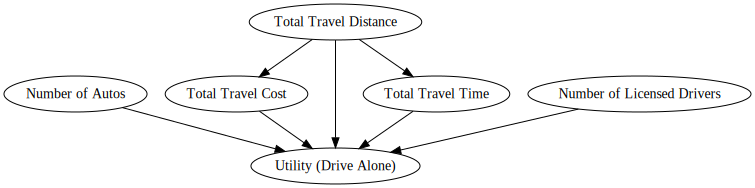

In [46]:
# Define the causal model
V_Drive_Alone = CausalGraphicalModel(nodes=["Total Travel Distance",
                                            "Total Travel Time",
                                            "Total Travel Cost",
                                            "Number of Autos",
                                            "Number of Licensed Drivers",
                                            "Utility (Drive Alone)"],
                                     edges=[("Total Travel Distance","Total Travel Time"),
                                            ("Total Travel Distance","Total Travel Cost"),
                                            ("Total Travel Time", "Utility (Drive Alone)"), 
                                            ("Total Travel Cost", "Utility (Drive Alone)"), 
                                            ("Number of Autos", "Utility (Drive Alone)"),
                                            ("Total Travel Distance", "Utility (Drive Alone)"),
                                            ("Number of Licensed Drivers","Utility (Drive Alone)")
    ]
)

# draw the causal model
V_Drive_Alone.draw()

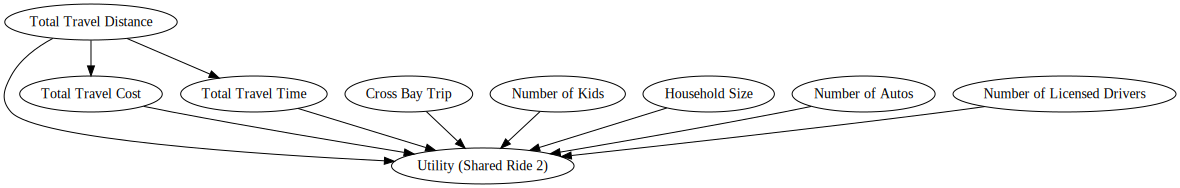

In [50]:
# Define the causal model
V_Shared_2 = CausalGraphicalModel(nodes=["Total Travel Time",
                                         "Total Travel Distance",
                                         "Total Travel Cost",
                                         "Cross Bay Trip",
                                         "Number of Autos",
                                         "Number of Licensed Drivers",
                                         "Household Size",
                                         "Number of Kids",
                                         "Utility (Shared Ride 2)"],
                                  edges=[("Total Travel Distance","Total Travel Time"),
                                         ("Total Travel Distance","Total Travel Cost"),
                                         ("Total Travel Distance", "Utility (Shared Ride 2)"),
                                         ("Total Travel Time", "Utility (Shared Ride 2)"),
                                         ("Number of Autos", "Utility (Shared Ride 2)"),
                                         ("Number of Licensed Drivers", "Utility (Shared Ride 2)"),
                                         ("Total Travel Cost", "Utility (Shared Ride 2)"),
                                         ("Household Size", "Utility (Shared Ride 2)"),
                                         ("Cross Bay Trip", "Utility (Shared Ride 2)"),
                                         ("Number of Kids", "Utility (Shared Ride 2)")
    ]
)

# draw the causal model
V_Shared_2.draw()

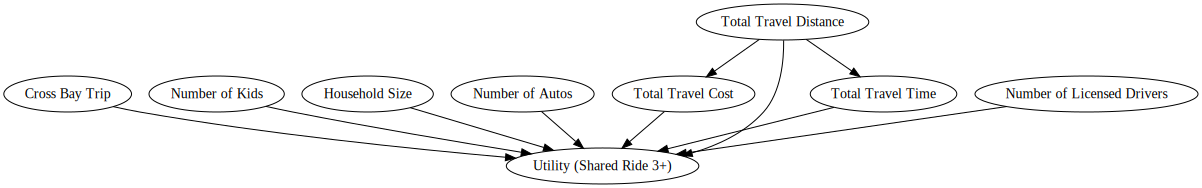

In [51]:
# Define the causal model
V_Shared_3p = CausalGraphicalModel(nodes=["Total Travel Time",
                                         "Total Travel Distance",
                                         "Total Travel Cost",
                                         "Cross Bay Trip",
                                         "Number of Autos",
                                         "Number of Licensed Drivers",
                                         "Household Size",
                                         "Number of Kids",
                                         "Utility (Shared Ride 3+)"],
                                  edges=[("Total Travel Distance","Total Travel Time"),
                                         ("Total Travel Distance","Total Travel Cost"),
                                         ("Total Travel Distance", "Utility (Shared Ride 3+)"),
                                         ("Total Travel Time", "Utility (Shared Ride 3+)"),
                                         ("Number of Autos", "Utility (Shared Ride 3+)"),
                                         ("Number of Licensed Drivers", "Utility (Shared Ride 3+)"),
                                         ("Total Travel Cost", "Utility (Shared Ride 3+)"),
                                         ("Household Size", "Utility (Shared Ride 3+)"),
                                         ("Cross Bay Trip", "Utility (Shared Ride 3+)"),
                                         ("Number of Kids", "Utility (Shared Ride 3+)")
    ]
)

# draw the causal model
V_Shared_3p.draw()

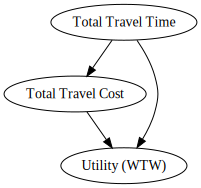

In [53]:
# Define the causal model
V_WTW = CausalGraphicalModel(nodes=["Total Travel Time",
                                    "Total Travel Cost",
                                    "Utility (WTW)"],
                                  edges=[("Total Travel Time", "Total Travel Cost"),
                                         ("Total Travel Time", "Utility (WTW)"),
                                         ("Total Travel Cost", "Utility (WTW)")
    ]
)

# draw the causal model
V_WTW.draw()

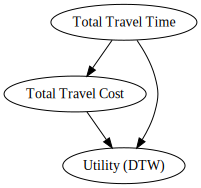

In [54]:
# Define the causal model
V_DTW = CausalGraphicalModel(nodes=["Total Travel Time",
                                    "Total Travel Cost",
                                    "Utility (DTW)"],
                             edges=[("Total Travel Time", "Total Travel Cost"),
                                    ("Total Travel Time", "Utility (DTW)"),
                                    ("Total Travel Cost", "Utility (DTW)")
    ]
)

# draw the causal model
V_DTW.draw()

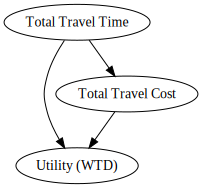

In [55]:
# Define the causal model
V_WTD = CausalGraphicalModel(nodes=["Total Travel Time",
                                    "Total Travel Cost",
                                    "Utility (WTD)"],
                             edges=[("Total Travel Time", "Total Travel Cost"),
                                    ("Total Travel Time", "Utility (WTD)"),
                                    ("Total Travel Cost", "Utility (WTD)")
    ]
)

# draw the causal model
V_WTD.draw()

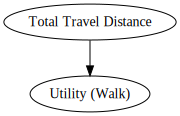

In [56]:
# Define the causal model
V_Walk = CausalGraphicalModel(nodes=["Total Travel Distance",
                                     "Utility (Walk)"],
                              edges=[("Total Travel Distance", "Utility (Walk)")
    ]
)

# draw the causal model
V_Walk.draw()

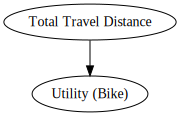

In [57]:
# Define the causal model
V_Bike = CausalGraphicalModel(nodes=["Total Travel Distance",
                                     "Utility (Bike)"],
                              edges=[("Total Travel Distance", "Utility (Bike)")
    ]
)

# draw the causal model
V_Bike.draw()

## 3.2. Distribution of Nodes without parents

### 3.2.1. Set up all needed variables

In [58]:
# Observation id column
observation_id_col = 'observation_id'

# Alternative id column
alternative_id_col = 'mode_id'

# Individual specific variables list
individual_specific_variables = ['household_size','num_kids',
                                'num_cars','num_licensed_drivers']

# Alternative specific variables dictionary
alternative_specific_dict = {1: ['total_travel_distance'],
                             2: ['total_travel_distance'],
                             3: ['total_travel_distance'],
                             4: ['total_travel_time'],
                             5: ['total_travel_time'],
                             6: ['total_travel_time'],
                             7: ['total_travel_distance'],
                             8: ['total_travel_distance']}

# Trip specific variables list
trip_specific_variables = ['cross_bay']

# Alternative name dictionary
alternative_name_dict = {1: 'drive_alone',
                         2: 'shared_2',
                         3: 'shared_3p',
                         4: 'wtw',
                         5: 'dtw',
                         6: 'wtd',
                         7: 'walk',
                         8: 'bike'}

# Variable type Dictionary
variable_type = {'num_kids': 'categorical',
                 'household_size': 'categorical',
                 'num_cars': 'categorical',
                 'num_licensed_drivers': 'categorical',
                 'cross_bay': 'categorical',
                 'total_travel_time': 'continuous',
                 'total_travel_distance': 'continuous',
                 'total_travel_cost': 'continuous'}

# Distribution to be explored for continuous variables
distributions = ['norm', 'alpha', 'beta', 'gamma', 'expon', 'gumbel']

### 3.2.2. Find Distributions of nodes without parents 

In [59]:
bike_data_params = DistNodeNoParent(data_long=bike_data_long,
                                    alt_id_col=alternative_id_col,
                                    obs_id_col=observation_id_col,
                                    alt_spec_dic=alternative_specific_dict,
                                    alt_name_dic=alternative_name_dict,
                                    ind_spec=individual_specific_variables,
                                    trip_spec=trip_specific_variables,
                                    var_types=variable_type,
                                    cont_dists=distributions)

Fitted norm distribution with error=0.014164054487182288)
Fitted alpha distribution with error=0.014522128648725777)
Fitted beta distribution with error=0.0011963782652540424)

/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2381: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:515: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)



Fitted gamma distribution with error=0.0011394543473683448)
Fitted expon distribution with error=0.002052652669300775)
SKIPPED gumbel distribution (taking more than 60 seconds)
Fitted norm distribution with error=0.014136723006166226)
Fitted alpha distribution with error=0.014457810916552023)
Fitted beta distribution with error=0.0012976882508515305)
Fitted gamma distribution with error=0.0012552378475140624)
Fitted expon distribution with error=0.0019967778289294194)
SKIPPED gumbel distribution (taking more than 60 seconds)
Fitted norm distribution with error=0.014117434128009247)
Fitted alpha distribution with error=0.014462601227138085)
Fitted beta distribution with error=0.001276124018206852)
Fitted gamma distribution with error=0.0012547975031013958)
Fitted expon distribution with error=0.0020004181046601524)
SKIPPED gumbel distribution (taking more than 60 seconds)
Fitted norm distribution with error=0.0004036911862300816)
Fitted alpha distribution with error=0.00010782141835446

In [60]:
bike_data_params

{'household_size': {'distribution': 'categorical',
  'parameters': [array([0., 1., 2., 3., 4., 5., 6., 7., 8.]),
   array([0.        , 0.08341658, 0.2465035 , 0.20704296, 0.29220779,
          0.12012987, 0.02997003, 0.00949051, 0.01123876])]},
 'num_kids': {'distribution': 'categorical',
  'parameters': [array([0, 1, 2, 3, 4, 5, 6]),
   array([0.46603397, 0.17682318, 0.25624376, 0.07642358, 0.01598402,
          0.00699301, 0.0014985 ])]},
 'num_cars': {'distribution': 'categorical',
  'parameters': [array([0., 1., 2., 3., 4., 5., 6., 7., 8.]),
   array([0.0516983 , 0.23976024, 0.48676324, 0.17057942, 0.03996004,
          0.00674326, 0.0024975 , 0.000999  , 0.000999  ])]},
 'num_licensed_drivers': {'distribution': 'categorical',
  'parameters': [array([0., 1., 2., 3., 4., 5., 6.]),
   array([1.12387612e-02, 1.45604396e-01, 6.15134865e-01, 1.73576424e-01,
          4.47052947e-02, 9.24075924e-03, 4.99500500e-04])]},
 'total_travel_distance_drive_alone': {'distribution': 'gamma',
  'pa

## 3.3. Regressions for each causal graph 

### 3.3.1. Drive Alone 

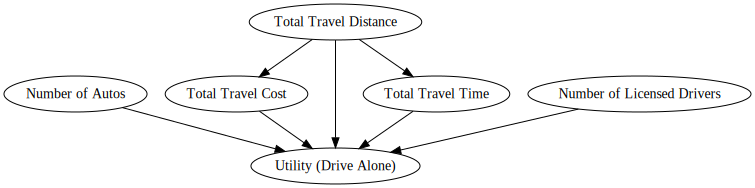

In [61]:
V_Drive_Alone.draw()

In [62]:
Drive_Alone_Df = bike_data_long[bike_data_long['mode_id']==1]
Drive_Alone_Df.reset_index(drop=True,inplace=True)
Drive_Alone_Reg = FitAlternativeRegression(regressions={1:('total_travel_distance','total_travel_cost'),
                                                        2:('total_travel_distance','total_travel_time')},
                                           reg_types={1:'linear',2:'linear'},
                                           data = Drive_Alone_Df)

/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### 3.3.2. Shared-2

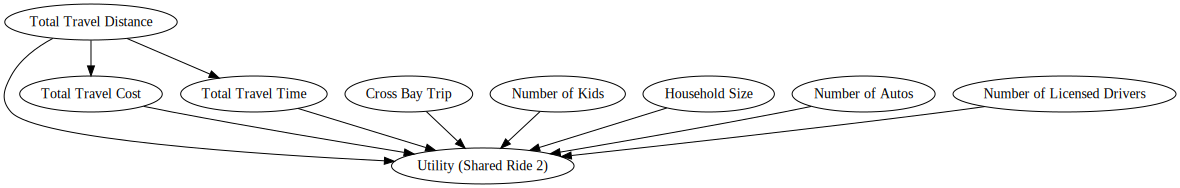

In [63]:
V_Shared_2.draw()

In [64]:
Shared_2_Df = bike_data_long[bike_data_long['mode_id']==2]
Shared_2_Df.reset_index(drop=True,inplace=True)
Shared_2_Reg = FitAlternativeRegression(regressions={1:('total_travel_distance','total_travel_cost'),
                                                        2:('total_travel_distance','total_travel_time')},
                                           reg_types={1:'linear',2:'linear'},
                                           data = Shared_2_Df)

/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### 3.3.3. Shared-3+

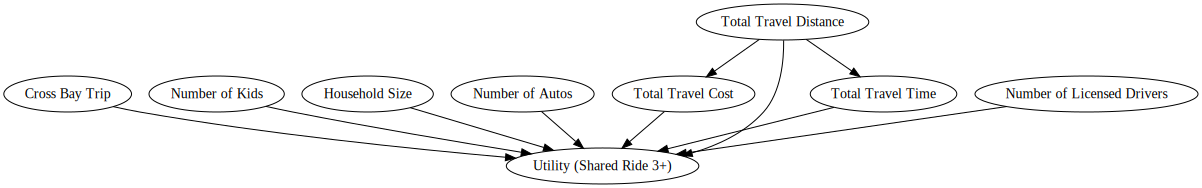

In [65]:
V_Shared_3p.draw()

In [66]:
Shared_3p_Df = bike_data_long[bike_data_long['mode_id']==3]
Shared_3p_Df.reset_index(drop=True,inplace=True)
Shared_3p_Reg = FitAlternativeRegression(regressions={1:('total_travel_distance','total_travel_cost'),
                                                        2:('total_travel_distance','total_travel_time')},
                                           reg_types={1:'linear',2:'linear'},
                                           data = Shared_3p_Df)

/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### 3.3.4. Walk-Transit-Walk 

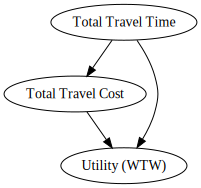

In [67]:
V_WTW.draw()

In [68]:
WTW_Df = bike_data_long[bike_data_long['mode_id']==4]
WTW_Df.reset_index(drop=True,inplace=True)
WTW_Reg = FitAlternativeRegression(regressions={1:('total_travel_time','total_travel_cost')},
                                           reg_types={1:'linear'},
                                           data = WTW_Df)

/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### 3.3.5. Drive-Transit-Walk 

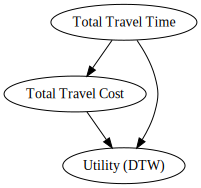

In [69]:
V_DTW.draw()

In [70]:
DTW_Df = bike_data_long[bike_data_long['mode_id']==5]
DTW_Df.reset_index(drop=True,inplace=True)
DTW_Reg = FitAlternativeRegression(regressions={1:('total_travel_time','total_travel_cost')},
                                           reg_types={1:'linear'},
                                           data = DTW_Df)

/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### 3.3.6. Walk-Transit-Drive 

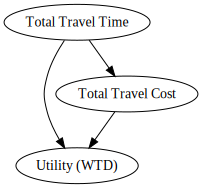

In [71]:
V_WTD.draw()

In [72]:
WTD_Df = bike_data_long[bike_data_long['mode_id']==6]
WTD_Df.reset_index(drop=True,inplace=True)
WTD_Reg = FitAlternativeRegression(regressions={1:('total_travel_time','total_travel_cost')},
                                           reg_types={1:'linear'},
                                           data = WTD_Df)

/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### 3.3.7. Walk

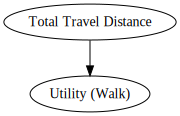

In [73]:
V_Walk.draw()

No regressions needed under the Walk alternative since the travel distance will be simulated based on the original dataset and directly affects the utility function

### 3.3.8. Bike

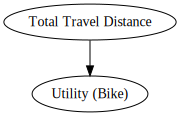

In [74]:
V_Bike.draw()

No regressions needed under the Bike alternative since the travel distance will be simulated based on the original dataset and directly affects the utility function

## 3.4. Simulate Nodes without Parents 

In [75]:
sim_size = 8000
sim_bike_data_no_parent = SimNodeNoParent(bike_data_params, size=sim_size)

## 3.5. Simulate data for each causal graph

In [76]:
# Create a copy of the data to avoid any issues
sim_bike_data_wide = copy.deepcopy(sim_bike_data_no_parent)

### 3.5.1. Drive Alone 

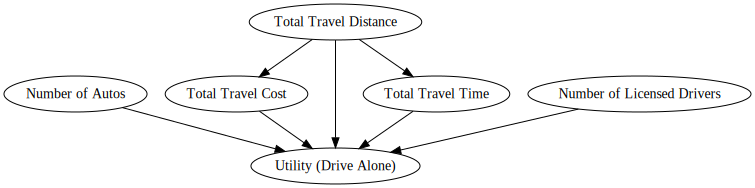

In [77]:
V_Drive_Alone.draw()

In [78]:
sim_bike_data_wide['total_travel_time_drive_alone'] = Drive_Alone_Reg['total_travel_time_on_total_travel_distance'].params[0] +\
                                                  Drive_Alone_Reg['total_travel_time_on_total_travel_distance'].params[1] *\
                                                  sim_bike_data_wide['total_travel_distance_drive_alone'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = Drive_Alone_Reg['total_travel_time_on_total_travel_distance'].resid.std(),
                                                                   size = sim_size)
sim_bike_data_wide['total_travel_cost_drive_alone'] = Drive_Alone_Reg['total_travel_cost_on_total_travel_distance'].params[0] +\
                                                  Drive_Alone_Reg['total_travel_cost_on_total_travel_distance'].params[1] *\
                                                  sim_bike_data_wide['total_travel_distance_drive_alone'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = Drive_Alone_Reg['total_travel_cost_on_total_travel_distance'].resid.std(),
                                                                   size = sim_size)

### 3.5.2. Shared-2 

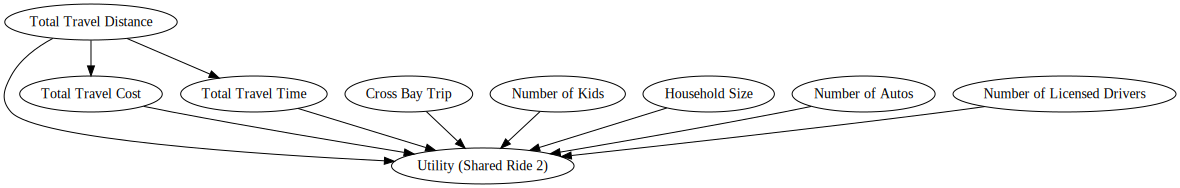

In [79]:
V_Shared_2.draw()

In [80]:
sim_bike_data_wide['total_travel_time_shared_2'] = Shared_2_Reg['total_travel_time_on_total_travel_distance'].params[0] +\
                                               Shared_2_Reg['total_travel_time_on_total_travel_distance'].params[1] *\
                                                  sim_bike_data_wide['total_travel_distance_shared_2'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = Shared_2_Reg['total_travel_time_on_total_travel_distance'].resid.std(),
                                                                   size = sim_size)
sim_bike_data_wide['total_travel_cost_shared_2'] = Shared_2_Reg['total_travel_cost_on_total_travel_distance'].params[0] +\
                                                  Shared_2_Reg['total_travel_cost_on_total_travel_distance'].params[1] *\
                                                  sim_bike_data_wide['total_travel_distance_shared_2'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = Shared_2_Reg['total_travel_cost_on_total_travel_distance'].resid.std(),
                                                                   size = sim_size)

### 3.5.3. Shared-3+

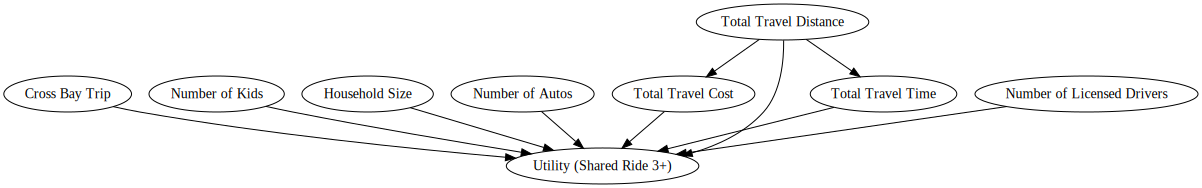

In [81]:
V_Shared_3p.draw()

In [82]:
sim_bike_data_wide['total_travel_time_shared_3p'] = Shared_3p_Reg['total_travel_time_on_total_travel_distance'].params[0] +\
                                               Shared_3p_Reg['total_travel_time_on_total_travel_distance'].params[1] *\
                                                  sim_bike_data_wide['total_travel_distance_shared_3p'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = Shared_3p_Reg['total_travel_time_on_total_travel_distance'].resid.std(),
                                                                   size = sim_size)
sim_bike_data_wide['total_travel_cost_shared_3p'] = Shared_3p_Reg['total_travel_cost_on_total_travel_distance'].params[0] +\
                                                  Shared_3p_Reg['total_travel_cost_on_total_travel_distance'].params[1] *\
                                                  sim_bike_data_wide['total_travel_distance_shared_3p'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = Shared_3p_Reg['total_travel_cost_on_total_travel_distance'].resid.std(),
                                                                   size = sim_size)

### 3.5.4. Walk-Transit-Walk

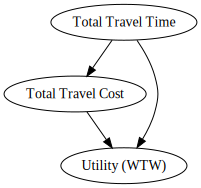

In [83]:
V_WTW.draw()

In [84]:
sim_bike_data_wide['total_travel_cost_wtw'] = WTW_Reg['total_travel_cost_on_total_travel_time'].params[0] +\
                                                  WTW_Reg['total_travel_cost_on_total_travel_time'].params[1] *\
                                                  sim_bike_data_wide['total_travel_time_wtw'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = WTW_Reg['total_travel_cost_on_total_travel_time'].resid.std(),
                                                                   size = sim_size)

### 3.5.5. Drive-Transit-Walk

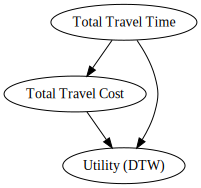

In [85]:
V_DTW.draw()

In [86]:
sim_bike_data_wide['total_travel_cost_dtw'] = DTW_Reg['total_travel_cost_on_total_travel_time'].params[0] +\
                                                  DTW_Reg['total_travel_cost_on_total_travel_time'].params[1] *\
                                                  sim_bike_data_wide['total_travel_time_dtw'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = DTW_Reg['total_travel_cost_on_total_travel_time'].resid.std(),
                                                                   size = sim_size)

### 3.5.6. Walk-Transit-Drive

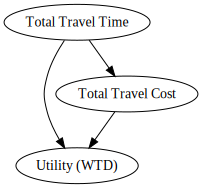

In [87]:
V_WTD.draw()

In [88]:
sim_bike_data_wide['total_travel_cost_wtd'] = WTD_Reg['total_travel_cost_on_total_travel_time'].params[0] +\
                                                  WTD_Reg['total_travel_cost_on_total_travel_time'].params[1] *\
                                                  sim_bike_data_wide['total_travel_time_wtd'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = WTD_Reg['total_travel_cost_on_total_travel_time'].resid.std(),
                                                                   size = sim_size)

### 3.5.7. Walk

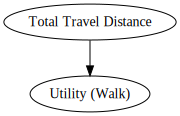

In [89]:
V_Walk.draw()

No need to simulate any other variables since Walk Total Travel Distance was already simulated

### 3.5.8. Bike

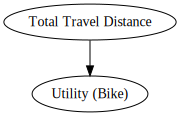

In [90]:
V_Bike.draw()

No need to simulate any other variables since Bike Total Travel Distance was already simulated

## 3.6. Simulate Availability of Alternatives 

In [91]:
# Simulate availability, add fake choice column
# and return final simulated data with availability
# and choices
wide_sim_data_availability = SimulateAvailability(data_long=bike_data_long,
                                     sim_data=sim_bike_data_wide,
                                     obs_id_col=observation_id_col,
                                     alt_name_dict=alternative_name_dict)

In [92]:
wide_sim_data_availability

,household_size,num_kids,num_cars,num_licensed_drivers,total_travel_distance_drive_alone,total_travel_distance_shared_2,total_travel_distance_shared_3p,total_travel_time_wtw,total_travel_time_dtw,total_travel_time_wtd,...,total_travel_cost_wtd,drive_alone_AV,shared_2_AV,shared_3p_AV,wtw_AV,dtw_AV,wtd_AV,walk_AV,bike_AV,sim_choice
0,3.0,1,2.0,3.0,20.850240,12.454241,1.350297,102.434669,79.962397,132.782650,...,5.353805,1,1,1,1,1,1,1,1,4
1,4.0,0,3.0,2.0,11.233122,15.437256,2.559020,462.909871,105.368345,66.612428,...,3.684948,1,1,1,1,1,1,1,1,2
2,4.0,2,2.0,2.0,3.578253,1.297888,8.347218,45.784034,111.916229,35.248226,...,4.034440,1,0,1,1,1,1,1,1,3
3,3.0,5,2.0,2.0,26.773473,5.384989,0.615827,44.292189,33.805903,33.764792,...,1.854377,1,1,1,1,1,1,1,1,3
4,2.0,0,2.0,3.0,70.261580,71.669147,2.203971,85.368814,149.338782,17.035746,...,6.512575,1,0,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,5.0,2,3.0,2.0,3.105132,32.961492,6.700082,49.430536,114.223060,189.281350,...,7.219164,1,0,1,1,1,1,1,1,6
7996,7.0,2,2.0,4.0,3.508000,84.309187,1.068463,89.112757,130.533823,67.246742,...,3.138791,1,1,1,1,1,1,1,1,5
7997,5.0,1,1.0,3.0,19.033986,1.123416,2.085327,70.854409,104.446258,175.793443,...,6.688160,1,1,0,1,1,1,1,1,1
7998,4.0,0,0.0,2.0,2.653514,22.883622,45.495393,141.421367,34.839868,47.623582,...,-0.686852,1,0,1,0,1,0,1,1,7


## 3.7. Convert Simulated Data from Wide to Long

In [93]:
ind_variables = ['num_kids', 'household_size',
                 'num_cars', 'num_licensed_drivers', 'cross_bay']



# Dictionary of Alternative Specific Variables
# TODO: verify whether all variables are needed
# for each alternative
alt_varying_variables = {u'total_travel_time': dict([(1, 'total_travel_time_drive_alone'),
                                                     (2, 'total_travel_time_shared_2'),
                                                     (3, 'total_travel_time_shared_3p'),
                                                     (4, 'total_travel_time_wtw'),
                                                     (5, 'total_travel_time_dtw'),
                                                     (6, 'total_travel_time_wtd')]),
                         u'total_travel_cost': dict([(1, 'total_travel_cost_drive_alone'),
                                                     (2, 'total_travel_cost_shared_2'),
                                                     (3, 'total_travel_cost_shared_3p'),
                                                     (4, 'total_travel_cost_wtw'),
                                                     (5, 'total_travel_cost_dtw'),
                                                     (6, 'total_travel_cost_wtd')]),
                         u'total_travel_distance': dict([(1, 'total_travel_distance_drive_alone'),
                                                         (2, 'total_travel_distance_shared_2'),
                                                         (3, 'total_travel_distance_shared_3p'),
                                                         (7, 'total_travel_distance_walk'),
                                                         (8, 'total_travel_distance_bike')]),
                            }


# Dictionary of alternative availability variables
availability_variables = {1: 'drive_alone_AV',
                          2: 'shared_2_AV',
                          3: 'shared_3p_AV',
                          4: 'wtw_AV',
                          5: 'dtw_AV',
                          6: 'wtd_AV',
                          7: 'walk_AV',
                          8: 'bike_AV'}

##########
# Determine the columns for: alternative ids, the observation ids and the choice
##########
# The 'custom_alt_id' is the name of a column to be created in the long-format data
# It will identify the alternative associated with each row.
custom_alt_id = "mode_id"

# Create a custom id column that ignores the fact that this is a
# panel/repeated-observations dataset. Note the +1 ensures the id's start at one.
obs_id_column = "observation_id"
wide_sim_data_availability[obs_id_column] = np.arange(wide_sim_data_availability.shape[0],
                                         dtype=int) + 1


# Declare choice column
choice_column = "sim_choice"

In [94]:
# Convert data from wide to long
long_sim_data = pl.convert_wide_to_long(wide_sim_data_availability,
                                        ind_variables,
                                        alt_varying_variables,
                                        availability_variables,
                                        obs_id_column,
                                        choice_column,
                                        new_alt_id_name=custom_alt_id)

In [95]:
# Create a cars per licensed drivers column
long_sim_data["cars_per_licensed_drivers"] = 0
long_sim_data.loc[long_sim_data.num_licensed_drivers > 0,
                  "cars_per_licensed_drivers"] = long_sim_data.num_cars / long_sim_data.num_licensed_drivers.astype(float)

In [96]:
# Add a variable representing cost divided by distance
long_sim_data["cost_per_distance"] = 0
long_sim_data.loc[long_sim_data.mode_id.isin([1, 2, 3]),
                  "cost_per_distance"] = (long_sim_data.loc[long_sim_data.mode_id.isin([1, 2, 3]),
                                                            "total_travel_cost"] /
                                          long_sim_data.loc[long_sim_data.mode_id.isin([1, 2, 3]),
                                                            "total_travel_distance"])

## 3.8. Simulate Choices 

In [97]:
# Calculate probabilities for each alternative
# based on the adjusted parameters of the estimated model
posterior_probs = mnl_model.predict(long_sim_data, param_list=[adjusted_parameters, None, None, None])

/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


In [98]:
# Simulate choice data
long_sim_data['sim_choice'] = viz.simulate_choice_vector(posterior_probs,
                               long_sim_data['observation_id'].values)

## 3.9. Estimate Model

In [99]:
# Estimate the basic MNL model, using the hessian and newton-conjugate gradient
mnl_model_sim = pl.create_choice_model(data=long_sim_data,
                                           alt_id_col=alternative_id_col,
                                           obs_id_col=observation_id_col,
                                           choice_col=choice_column,
                                           specification=mnl_specification,
                                           model_type="MNL",
                                           names=mnl_names)

num_vars = len(reduce(lambda x, y: x + y, mnl_names.values()))

# Note newton-cg used to ensure convergence to a point where gradient 
# is essentially zero for all dimensions. 
mnl_model_sim.fit_mle(np.zeros(num_vars),
                      method="BFGS")

# Look at the estimation results
mnl_model_sim.get_statsmodels_summary()

Log-likelihood at zero: -15,176.6986
Initial Log-likelihood: -15,176.6986


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.56 seconds.
Final log-likelihood: -8,116.6614


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                  sim_choice   No. Observations:                8,000
Model:             Multinomial Logit Model   Df Residuals:                    7,976
Method:                                MLE   Df Model:                           24
Date:                     Sat, 02 May 2020   Pseudo R-squ.:                   0.465
Time:                             17:27:41   Pseudo R-bar-squ.:               0.464
AIC:                            16,281.323   Log-Likelihood:             -8,116.661
BIC:                            16,449.016   LL-Null:                   -15,176.699
====================================================================================================================
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
ASC Shared Ride: 2                                  -1.4806      0.125    -11.831      0.000      -1.726      -1.235
ASC Shared Ride: 3+                                 -1.0591      0.135     -7.847      0.000      -1.324      -0.795
ASC Walk-Transit-Walk                                0.9292      0.131      7.078      0.000       0.672       1.186
ASC Drive-Transit-Walk                              -1.4083      0.145     -9.716      0.000      -1.692      -1.124
ASC Walk-Transit-Drive                              -1.6138      0.150    -10.788      0.000      -1.907      -1.321
ASC Walk                                             3.0480      0.135     22.606      0.000       2.784       3.312
ASC Bike                                             0.2714      0.103      2.627      0.009       0.069       0.474
Travel Time, units:min (Drive Alone)                -0.0844      0.005    -16.886      0.000      -0.094      -0.075
Travel Time, units:min (SharedRide-2)               -0.0903      0.006    -14.750      0.000      -0.102      -0.078
Travel Time, units:min (SharedRide-3+)              -0.1261      0.008    -16.050      0.000      -0.141      -0.111
Travel Time, units:min (All Transit Modes)          -0.0297      0.002    -19.750      0.000      -0.033      -0.027
Travel Cost, units:$ (Drive Alone)                  -0.2292      0.026     -8.744      0.000      -0.281      -0.178
Travel Cost, units:$ (SharedRide-2)                 -0.4378      0.057     -7.636      0.000      -0.550      -0.325
Travel Cost, units:$ (SharedRide-3+)                -0.7461      0.157     -4.749      0.000      -1.054      -0.438
Travel Cost, units:$ (All Transit Modes)            -0.1180      0.019     -6.316      0.000      -0.155      -0.081
Autos per licensed drivers (All Auto Modes)          1.3336      0.055     24.051      0.000       1.225       1.442
Travel Distance, units:mi (Drive Alone)              0.1056      0.009     11.880      0.000       0.088       0.123
Travel Distance, units:mi (SharedRide-2)             0.0637      0.011      5.689      0.000       0.042       0.086
Travel Distance, units:mi (SharedRide-3+)            0.0359      0.017      2.057      0.040       0.002       0.070
Travel Distance, units:mi (Walk)                    -1.0998      0.037    -30.075      0.000      -1.171      -1.028
Travel Distance, units:mi (Bike)                    -0.3209      0.016    -20.290      0.000      -0.352      -0.290
Cross-Bay Tour (Shared Ride 2 & 3+)                  0.6706      0.123      5.459      0.000       0.430       0.911
Household Size (Shared Ride 2 & 3+)                  0.1142      0.022      5.194      0.000       0.071       0.157
Number of Kids in Household (Shared Ride 2 & 3+)     0.5737      0.026     21.827      0.000       0.522       0.625
=====================================

In [100]:
long_sim_data.to_csv('../../data/raw/simulated_long_format_bike_data.csv')